In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# This will reload imports before executing code, allowing you to easily change contents of custom scripts
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
import os, sys
sys.path.append('/home/sandm/Notebooks/stay_classification/src/')

# TODOs (from 09.06.2020)

1. Strip away the non-useful functions
2. Document the remaining functions
3. Move the remaining functions to modules
4. Test the modules
5. Clean up this NB

# Introduction: movement analysis

From a sequence of signaling events, _eg_ GPS measurements, determine locations where the user remains for a significant duration of time, called "stays". For each of these, there should be a beginning and end, as well as a location. 

Generally, this is meant for movement on the surface of the earth, but for present purposes, it is easiest to illustrate in one spatial dimension "1D"; all of the problems and strategies can be generalized to 2D as needed.

**Note** the signaling events for a given user, form a set $\mathcal{E} :=  \{e_i = (\mathbf{x}_i, t_i), i=[0,N-1] \; | \; t_{i+1}>t_i\}$

In [5]:
from synthetic_data.trajectory import get_stay
from synthetic_data.trajectory import get_journey_path, get_segments
from synthetic_data.masking import get_mask_with_duplicates
from synthetic_data.trajectory import get_stay_segs, get_adjusted_stays
from synthetic_data.noise import get_noisy_segs, get_noisy_path, get_noise_arr

dsec = 1/3600.0
time = np.arange(0,24,dsec)
stays = [
        get_stay(  0.00,  6.00,-1.00), #home
        get_stay(  7.50, 16.50, 1.00), #work, afternoon
        get_stay( 18.00, 24.00,-1.00)  # overnight
    ]

t_segs, x_segs = get_stay_segs(stays)


raw_journey = get_journey_path(time, get_segments(time, stays, threshold=0.5))


dup_mask = get_mask_with_duplicates(time, 0.05, 0.3)

time_sub = time[dup_mask]
raw_journey_sub = raw_journey[dup_mask]

segments = get_segments(time, stays, threshold=0.5)
new_stays = get_adjusted_stays(segments, time_sub)
new_t_segs, new_x_segs = get_stay_segs(new_stays)      

noises = get_noise_arr(0.02, 0.15, len(segments))

noise_segments = get_noisy_segs(segments, noises)

noise_journey_sub = get_noisy_path(time_sub, raw_journey_sub, noise_segments)

**Figure** in the above plot, time is on the "x"-axis. An interpretation of this motion, is that the user is initially making a "stay" at a location near $x=-1$, then makes another stay at $x=1$, ending with a return to the initial location. As with all of this data, there is an intrinsic noise that must be considered.

# Goal: Stay detection and positioning

The goal is to identify stays by their beginnings and ends, and associate them to a position. This effectively means to optimally match clusters of points with flat lines.

For a set of events within a cluster $\mathcal{C}_l =  \{e_i \; | \; i = [m,n]_l \subset [0,N-1]\}$, a "flat line" has $|\mathbf{x}_m-\mathbf{x}_n| = 0$. Again, this is easiest to see in 1D but it also holds in 2D.


# Strategy

To find the stays, we consider some requirements.

Firstly, there are two main requirements (previously noted):
1. identify the start/stop of a stay
2. estimate a dominant location, _ie_ the "central location" of the stay
    * this is where the agent spends the majority of the time, _e.g._ within a building, at a park, etc.

Then, there are some minor rquirements:
1. the clusters should contain a minimum number of points
2. the duration between the first and last points should exceed $\Delta t$
3. the clusters should be as long (in time) as possible
    * if there is a sufficient temporal break between two consecutive events without a significant location change, then on must specify how this is to be dealt with.
4. the clusters should contain as many events as possible

One additional requirement which affects all of the above: **cluster outliers should be identified and ignored** 
* outliers can change the central location and also the beginning/ending of the clusters
* from the calculation of the central location
    * counting them could still help in identifying a cluster wihtout using their position
    
All of these must be considered together.

This clearly defines an optimization problem: 
* maximize the length of the fit line, while 
    * mimimizing its error by adjusting its position ($\mathrm{x}_{\mathrm{opt.}}$) and end-regions ($t_{\mathrm{start}}, t_{\mathrm{stop}}$)
    * ignoring the outliers.

**Notes** 

* When the error is the mean squared error: $\epsilon := \sqrt{ \frac{1}{N}\sum^N_i(\mathrm{x}_i-\mathrm{x}_{\mathrm{opt.}})^2}$; 
    * this simplifies the position since the mean (or "centroid") is the value of $\mathrm{x}_{\mathrm{opt.}}$ which minimizes this error, leaving only the adjustment of the end-regions and outliers for the optimization task.

This suggests that there is at least a solution to this problem: 
One could consider all possible combinations of subsequences and all possible combinations of their outliers, and measure error, and then pick any from the set of lowest error subsequence-outlier combination fits. However, this is similar to the maximum subarray problem, and in the worst case it would be $\mathcal{O}(n^3)$.

It's countably finite, but impractical approach; itcan be a benchmark to compare all other algorithms which aim to do the same within some acceptable error.

In [6]:
import random
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, 20)]
random.shuffle(colors)

In [7]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

Once the box (width is provided by the spatial tolerance) is positioned in a good way (_ie_ the centroid), extending the box forwards or backwards in time makes no change to the _score_ of the box.

Here, the score could be something like the number of points, the std/MSE; whatever it is, it should be saturated at some point and extending the box makes no difference, meaning that something converges which provides a stopping criterion. 

## Testing the box method

In [8]:
eps = 0.25

In [9]:
rand_range = lambda size, max_, min_: (max_-min_)*np.random.random_sample(size=size) + min_

In [10]:
from synthetic_data.trajectory import get_stay
from synthetic_data.trajectory import get_journey_path, get_segments
from synthetic_data.masking import get_mask_with_duplicates
from synthetic_data.trajectory import get_stay_segs, get_adjusted_stays, get_stay_indices
from synthetic_data.noise import get_noisy_segs, get_noisy_path, get_noise_arr
from synthetic_data.noise import get_noisy_segs, get_noisy_path, get_noise_arr

In [11]:
from synthetic_data.trajectory_class import get_trajectory

In [12]:
dsec = 1/3600.0
time = np.arange(0,24,dsec)

In [13]:
segs_plot_kwargs = {'linestyle':'--', 'marker':'o', 'color':'k', 'linewidth':4.0, 'markerfacecolor':'w', 'markersize':6.0, 'markeredgewidth':2.0}

In [14]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

In [15]:
event_frac = rand_range(1,0.01,0.001)[0]

duplicate_frac = rand_range(1,0.3,0.05)[0]

print(event_frac, duplicate_frac)

configs = {
    'threshold':0.5,
    'event_frac':event_frac,
    'duplicate_frac':duplicate_frac,    
    'noise_min':0.02,
    'noise_max':0.15
}


nr_stays = np.random.randint(10)
stay_time_bounds = np.concatenate((np.array([0]),rand_range(2*nr_stays, 24, 0),np.array([24])))
stay_time_bounds = np.sort(stay_time_bounds)
stay_xlocs = rand_range(nr_stays+1, 2, - 2.0)

stays = []
for n in range(nr_stays+1):
    
    nn = 2*n
    stay = get_stay(stay_time_bounds[nn], stay_time_bounds[nn+1],  stay_xlocs[n])
    #print(n,nn,nn+1,stay)
    stays.append(stay)
    

time_sub, raw_journey_sub, noise_journey_sub = get_trajectory(stays, time, configs)

segments = get_segments(time, stays, threshold=0.5)
new_stays = get_adjusted_stays(segments, time_sub)
new_t_segs, new_x_segs = get_stay_segs(new_stays) 

0.0016648019275751175 0.050678435308105466


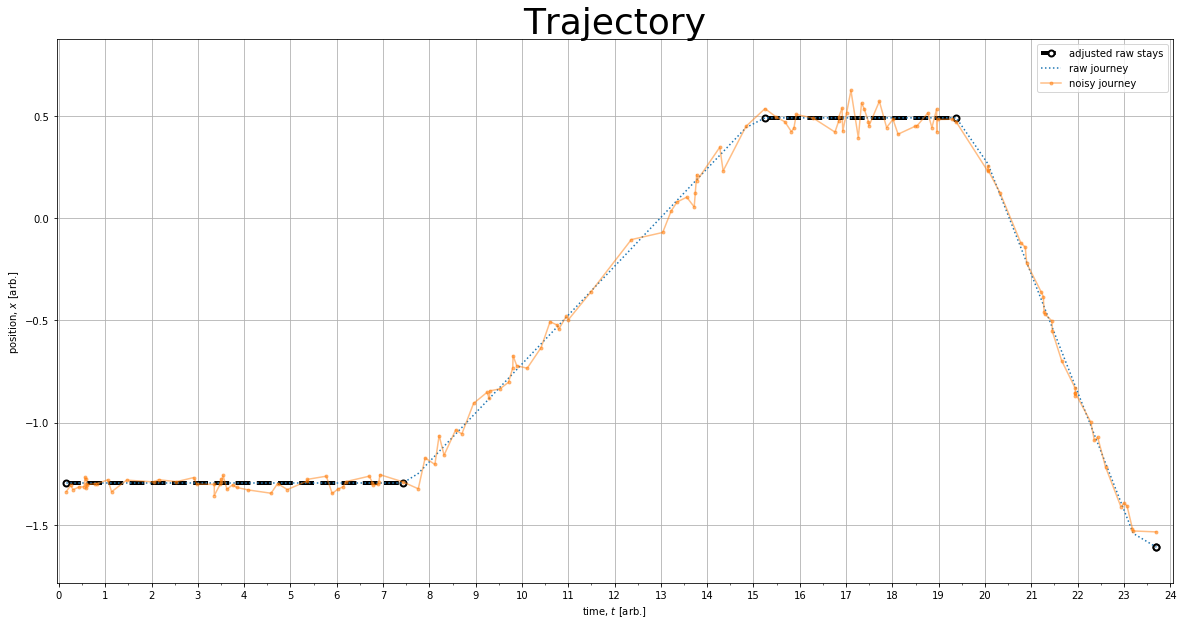

In [16]:
plt.figure(figsize=(20,10))
#plt.plot(t_segs, x_segs, ':', marker='|', color='grey', linewidth=2.0, markerfacecolor='w', markersize=30.0, markeredgewidth=1.0, dashes=[0.5,0.5], label='raw stays')

plt.plot(new_t_segs, new_x_segs, **segs_plot_kwargs, label='adjusted raw stays')
plt.plot(time_sub, raw_journey_sub, ':', label='raw journey')
plt.plot(time_sub, noise_journey_sub, '.-', label='noisy journey', alpha=0.5)

plt.legend();

plt.xlabel(r'time, $t$ [arb.]')
plt.ylabel(r'position, $x$ [arb.]')

ymin = noise_journey_sub.min()-1*eps
ymax = noise_journey_sub.max()+1*eps
plt.ylim(ymin, ymax)

ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(MultipleLocator(0.5))

plt.xlim(-0.05, 24.05)
#plt.xlim(-0.1, 19.1
#plt.xlim(15.1, 19.1)

plt.title('Trajectory', fontsize=36)
plt.grid(visible=True);

In [ ]:
def time_overlap(t0,t1,tt0,tt1):
    
    if ((t0>=tt0)&(t0<tt1)):
        return True
    elif ((t1>=tt0)&(t1<tt1)):
        return True
    elif ((t0 <= tt0) & (tt1 <= t1)):
        return True
    else:
        return False

In [ ]:
def check_true(t_s, t_l, tsegs):
    for t_1, t_2 in zip(tsegs.tolist()[::3],tsegs.tolist()[1::3]):
        if time_overlap(t_s, t_l, t_1, t_2 ): 
            return t_1, t_2

## Testing

**Note** 
* a box will extend too _far_ when
    * if the duration of constant mean is too long, 
    * if the number of events for a constant mean is too large
        * **!** need to consider numbers of samples because the samples can increase but time-delta not
* a box will cut too _early_ when
    * if the number of events for a temporal constant mean is too large
* The embedding  conditional really drops a lot of small and other stays.

**TODOs**

1. Make the new scripts into a new module 'box_classifier'

2. include a `for` classifier in the above

3. Rewrite the `for` classifier into a `while` classifier

In [17]:
from stay_classification.box_classifier.box_classify import box_classifier_core

In [18]:
configs = {
    'eps':0.25,
    'time_thresh':5/12,
    'slope_time_thresh':1.0,
    'slope_thresh':0.50,
    'count_thresh':50
}

In [19]:
eps = configs['eps']
time_thresh = configs['time_thresh']
slope_time_thresh = configs['slope_time_thresh']  
slope_thresh = configs['slope_thresh']
count_thresh = configs['count_thresh']

### Run 1


PLOT: ID #  1 - - - - - - - - - - - - - - - - - - - - - - - -
	0.162 0, 53 True: ; Pred: 0.162, 8.702 -1.280 


PLOT: ID #  2 - - - - - - - - - - - - - - - - - - - - - - - -
	10.412 54, 69 True: ; Pred: 8.955, 11.003 -0.697 


PLOT: ID #  3 - - - - - - - - - - - - - - - - - - - - - - - -
	12.412 71, 81 True: ; Pred: 12.361, 14.344 0.086 


PLOT: ID #  4 - - - - - - - - - - - - - - - - - - - - - - - -
	22.912 136, 141 True: ; Pred: 22.602, 23.199 -1.413 



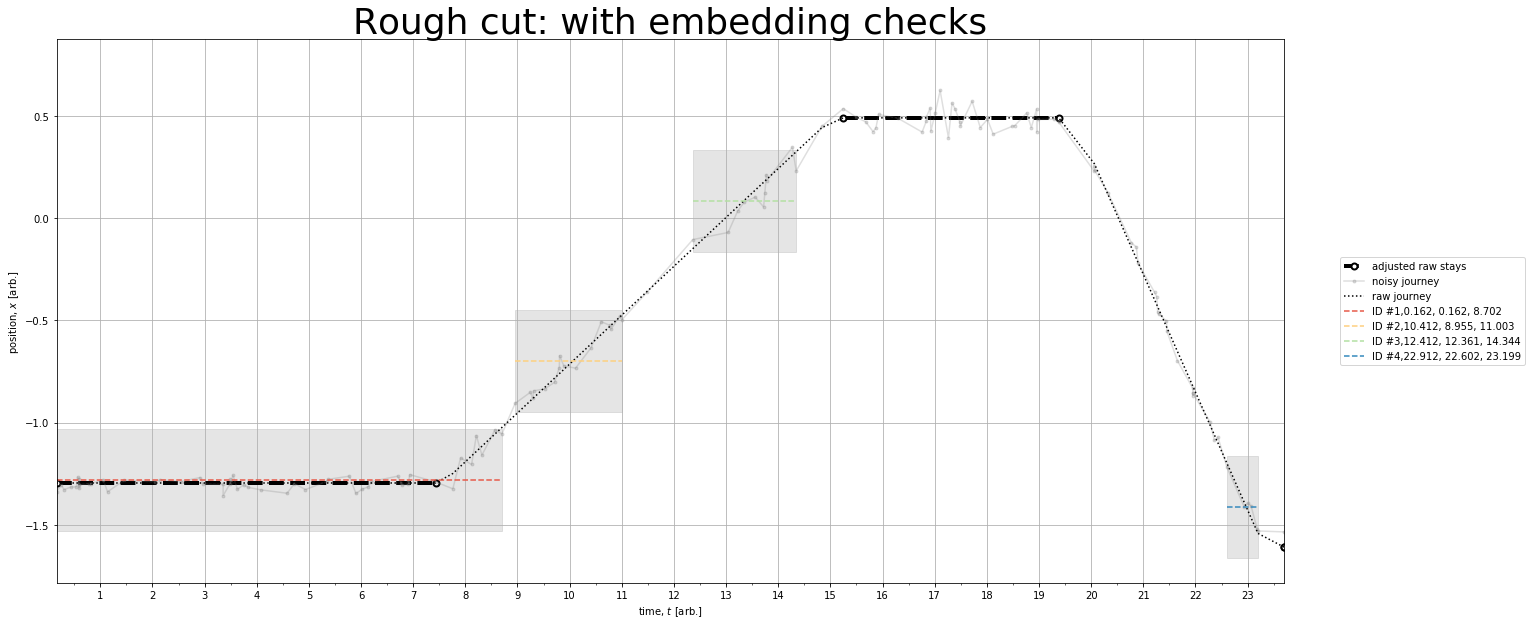

In [23]:
min_t, max_t = time_sub.min(), time_sub.max()

fig, ax = plt.subplots(1,1,figsize=(22,10))

# The adjusted raw-stays
plt.plot(new_t_segs, new_x_segs, **segs_plot_kwargs, label='adjusted raw stays')
ax.plot(time_sub, noise_journey_sub, '.-', color='gray', label='noisy journey', alpha=0.25)
ax.plot(time_sub, raw_journey_sub, ':', color='k', label='raw journey')

t0,t1 = 0,1
start_ind, last_ind = t0, t1

pairs = []

nnn = 0
t_diff = abs(time_sub[t1]-time_sub[t0])

for timepoint in np.arange(min_t,max_t,0.25):
   
    start_ind, last_ind, mean, keep = box_classifier_core(time_sub, noise_journey_sub, start_ind, last_ind, timepoint, pairs, configs, False)

    if keep:
        pairs.append([start_ind, last_ind,])
        nnn += 1
    else:
        continue

    # PLOTTING
    dashing = "-"+23*" -"
    ddashing = "="+30*"=="
    
    t_start = time_sub[start_ind]
    t_last = time_sub[last_ind]
    
    '''seg_ind = min(3*nnn+1,len(new_t_segs))
    t_seg_0 = new_t_segs[seg_ind-1]
    t_seg_1 = new_t_segs[seg_ind]'''
    #t_seg_0, t_seg_1 = check_true(t_start, t_last, new_t_segs)
    true_vals = ""
    '''if time_overlap(t_start, t_last, t_seg_0, t_seg_1 ):
        true_vals = f'{t_seg_0:2.3f}, {t_seg_1:2.3f}'    
    else:
        true_vals = 'Unmatched'
    '''
    true_vals = f"True: {true_vals};"

    print(f'\nPLOT: ID #{nnn:3d} {dashing}\n\t{timepoint:.3f}', \
          f'{start_ind}, {last_ind}', \
          true_vals,\
          f'Pred: {t_start:.3f}, {t_last:.3f}',\
          f'{mean:.3f}', \
          f'\n\n{ddashing}')
    
    #print(timepoint,":, mean, start_ind, last_ind)        
    ax.plot([time_sub[start_ind],time_sub[last_ind]], [mean,mean],\
            '--', color=colors[nnn%len(colors)], \
            label=f'ID #{nnn},{timepoint:.3f}, {time_sub[start_ind]:.3f}, {time_sub[last_ind]:.3f}')
    '''
    t_diff = abs(time_sub[t1]-time_sub[t0])
    ax.plot([time_sub[t0],time_sub[t1]], [mean,mean], '--', \
            dashes=[1,1], linewidth=5, color=colors[nnn], \
            label=f'ID #{nnn}: {round(t_diff,2)}, sub')
    '''
    # Add the box
    t_diff = time_sub[last_ind] -time_sub[start_ind]
    rect_color = "gray" #colors[nnn]
    rect = Rectangle((time_sub[start_ind], mean-eps), t_diff, 2*eps)
    pc = PatchCollection([rect], \
                         facecolor=rect_color, alpha=0.2, edgecolor=rect_color,linewidth=1)
    ax.add_collection(pc)
    
plt.xlabel(r'time, $t$ [arb.]')
plt.ylabel(r'position, $x$ [arb.]')

ymin = noise_journey_sub.min()-1*eps
ymax = noise_journey_sub.max()+1*eps
plt.ylim(ymin, ymax)


ax.xaxis.set_major_locator(MultipleLocator(1))
#ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))

# For the minor ticks, use no labels; default NullFormatter.
ax.xaxis.set_minor_locator(MultipleLocator(0.5))

plt.xlim(min_t, max_t)
#plt.xlim(-0.1, 19.1
#plt.xlim(15.1, 19.1)

plt.title('Rough cut: with embedding checks', fontsize=36)
plt.grid(visible=True);
plt.legend(bbox_to_anchor=(1.2, 0.5), loc='right', ncol=1);

#### Evaluate

In [24]:
true_indices = get_stay_indices(new_stays, time_sub)

In [25]:
true_labels = np.zeros(time_sub.shape)

In [26]:
for pair in true_indices:
    true_labels[pair[0]:pair[1]+1] = 1

In [27]:
np.sum(true_labels), true_labels.size-np.sum(true_labels), true_labels.size, np.sum(true_labels)/true_labels.size

(80.0, 63.0, 143, 0.5594405594405595)

In [28]:
pred_labels = np.zeros(time_sub.shape)
for pair in pairs:
    pred_labels[pair[0]:pair[1]+1] = 1

In [29]:
np.sum(pred_labels), pred_labels.size-np.sum(pred_labels), pred_labels.size, np.sum(pred_labels)/pred_labels.size

(87.0, 56.0, 143, 0.6083916083916084)

In [30]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score

In [31]:
confusion_matrix(true_labels, pred_labels)

array([[23, 40],
       [33, 47]])

In [32]:
precision_score(true_labels, pred_labels), recall_score(true_labels, pred_labels), 

(0.5402298850574713, 0.5875)

Thus in binary classification, the count of 
* true negatives is $C_{0,0}$, 
* false negatives is $C_{1,0}$, 
* true positives is $C_{1,1}$ and 
* false positives is $C_{0,1}$.

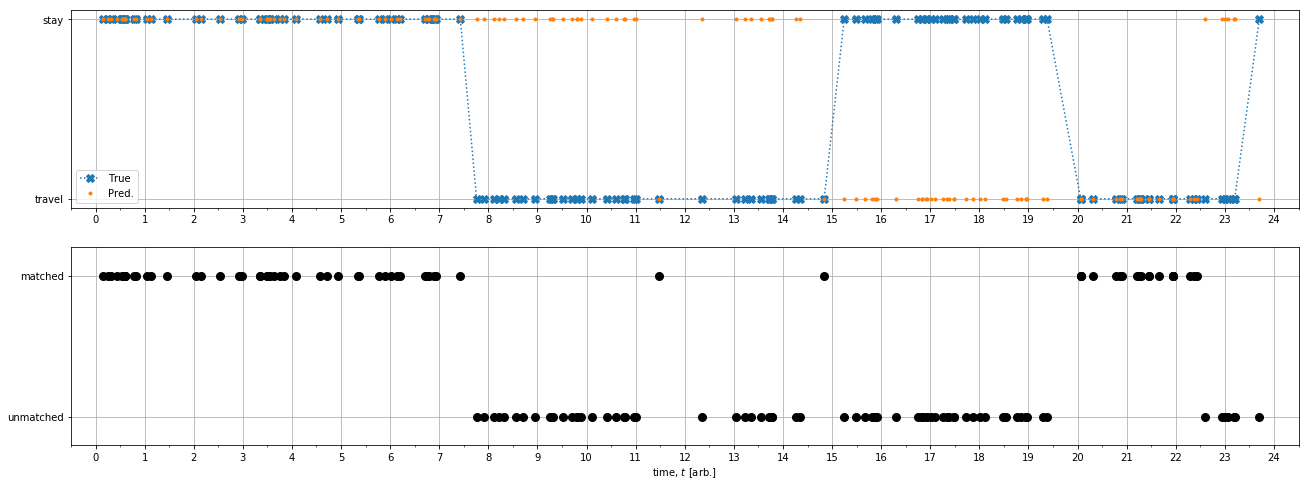

In [43]:
fig, ax = plt.subplots(2,1,figsize=(22,8))

ax = ax.flatten()

ax[0].plot(time_sub, true_labels, 'X:', markersize=8, label='True')
ax[0].plot(time_sub, pred_labels, '.', label='Pred.')
plt.ylim(-0.2,1.2)

ax[0].set_yticks([0,1])
ax[0].set_yticklabels(['travel', 'stay'])

ax[0].set_xlim(-0.5,24.5)
ax[0].set_xlabel(r'')


ax[0].legend()
ax[0].grid();
ax[0].xaxis.set_major_locator(MultipleLocator(1))
#ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
# For the minor ticks, use no labels; default NullFormatter.
ax[0].xaxis.set_minor_locator(MultipleLocator(0.5))

ax[1].plot(time_sub, true_labels==pred_labels, 'ko', markersize=8, label='True')
plt.ylim(-0.2,1.2)

ax[1].set_yticks([0,1])
ax[1].set_yticklabels(['unmatched', 'matched'])

ax[1].set_xlim(-0.5,24.5)
ax[1].set_xlabel(r'time, $t$ [arb.]')


#ax[1].legend()
ax[1].grid();
ax[1].xaxis.set_major_locator(MultipleLocator(1))
#ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
# For the minor ticks, use no labels; default NullFormatter.
ax[1].xaxis.set_minor_locator(MultipleLocator(0.5))


### Run 2


PLOT: ID #  0 - - - - - - - - - - - - - - - - - - - - - - - -
	9.119 0, 53 True: ; Pred: 0.162, 8.702 -1.280 


PLOT: ID #  1 - - - - - - - - - - - - - - - - - - - - - - - -
	11.420 54, 69 True: ; Pred: 8.955, 11.003 -0.697 


PLOT: ID #  2 - - - - - - - - - - - - - - - - - - - - - - - -
	14.761 71, 81 True: ; Pred: 12.361, 14.344 0.110 



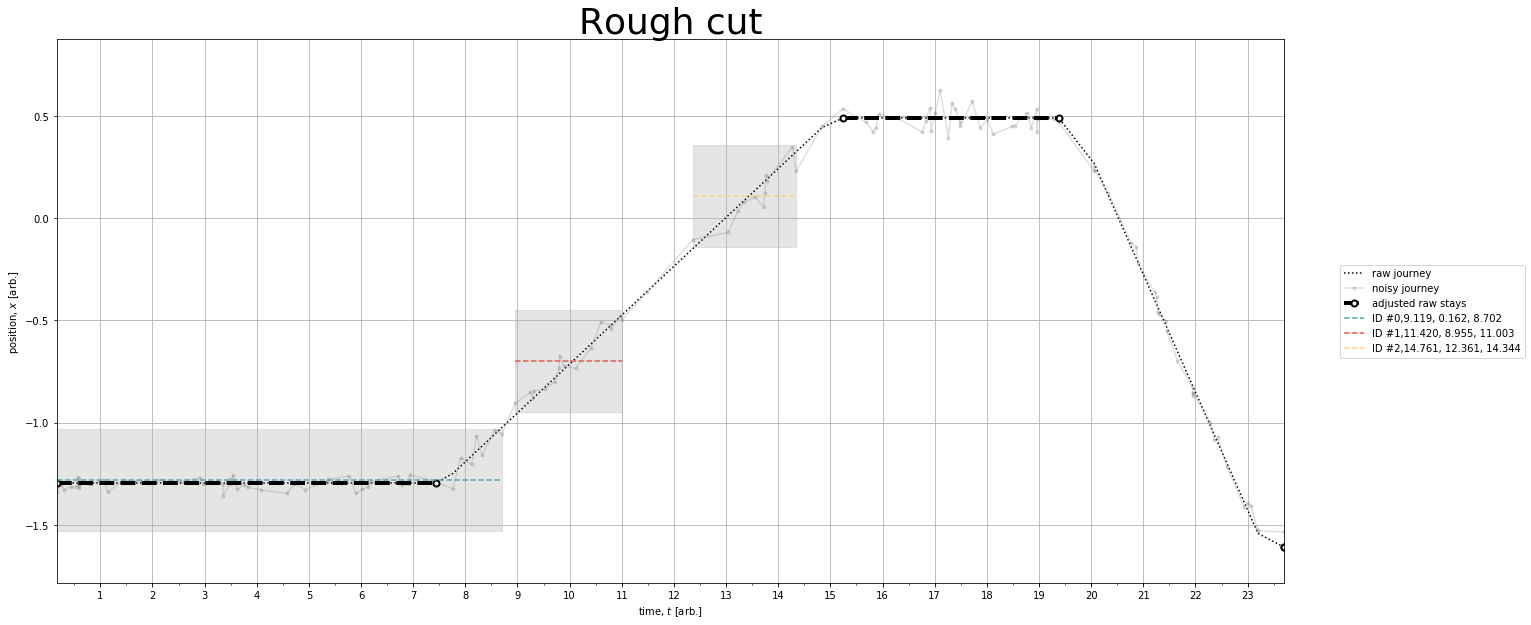

In [44]:
min_t, max_t = time_sub.min(), time_sub.max()

fig, ax = plt.subplots(1,1,figsize=(22,10))

# The adjusted raw-stays
ax.plot(time_sub, raw_journey_sub, ':', color='k', label='raw journey')
ax.plot(time_sub, noise_journey_sub, '.-', color='gray', label='noisy journey', alpha=0.25)
ax.plot(new_t_segs, new_x_segs, **segs_plot_kwargs, label='adjusted raw stays')

t0,t1 = 0,1
start_ind, last_ind = t0, t1

pairs = []

nnn = 0

timepoint = min_t

while timepoint < max_t:
   
    start_ind, last_ind, mean, keep = box_classifier_core(time_sub, noise_journey_sub, start_ind, last_ind, timepoint, pairs, configs, False)
    timepoint = time_sub[last_ind]+time_thresh
    if keep:
        pairs.append([start_ind, last_ind,])
        #nnn += 1
    else:
        continue

    # PLOTTING
    dashing = "-"+23*" -"
    ddashing = "="+30*"=="
    
    t_start = time_sub[start_ind]
    t_last = time_sub[last_ind]
    
    '''seg_ind = min(3*nnn+1,len(new_t_segs))
    t_seg_0 = new_t_segs[seg_ind-1]
    t_seg_1 = new_t_segs[seg_ind]'''
    #t_seg_0, t_seg_1 = check_true(t_start, t_last, new_t_segs)
    true_vals = ""
    '''if time_overlap(t_start, t_last, t_seg_0, t_seg_1 ):
        true_vals = f'{t_seg_0:2.3f}, {t_seg_1:2.3f}'    
    else:
        true_vals = 'Unmatched'
    '''
    true_vals = f"True: {true_vals};"

    print(f'\nPLOT: ID #{nnn:3d} {dashing}\n\t{timepoint:.3f}', \
          f'{start_ind}, {last_ind}', \
          true_vals,\
          f'Pred: {t_start:.3f}, {t_last:.3f}',\
          f'{mean:.3f}', \
          f'\n\n{ddashing}')
    
    #print(timepoint,":, mean, start_ind, last_ind)        
    ax.plot([time_sub[start_ind],time_sub[last_ind]], [mean,mean],\
            '--', color=colors[nnn], \
            label=f'ID #{nnn},{timepoint:.3f}, {time_sub[start_ind]:.3f}, {time_sub[last_ind]:.3f}')
    '''
    t_diff = abs(time_sub[t1]-time_sub[t0])
    ax.plot([time_sub[t0],time_sub[t1]], [mean,mean], '--', \
            dashes=[1,1], linewidth=5, color=colors[nnn], \
            label=f'ID #{nnn}: {round(t_diff,2)}, sub')
    '''
    # Add the box
    t_diff = time_sub[last_ind] -time_sub[start_ind]
    rect_color = "gray" #colors[nnn]
    rect = Rectangle((time_sub[start_ind], mean-eps), t_diff, 2*eps)
    pc = PatchCollection([rect], \
                         facecolor=rect_color, alpha=0.2, edgecolor=rect_color,linewidth=1)
    ax.add_collection(pc)
    

    nnn += 1
    
plt.xlabel(r'time, $t$ [arb.]')
plt.ylabel(r'position, $x$ [arb.]')

ymin = noise_journey_sub.min()-1*eps
ymax = noise_journey_sub.max()+1*eps
plt.ylim(ymin, ymax)


ax.xaxis.set_major_locator(MultipleLocator(1))
#ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))

# For the minor ticks, use no labels; default NullFormatter.
ax.xaxis.set_minor_locator(MultipleLocator(0.5))

plt.xlim(min_t, max_t)
#plt.xlim(-0.1, 19.1)
#plt.xlim(15.1, 19.1)

plt.title('Rough cut', fontsize=36)
plt.grid(visible=True);
plt.legend(bbox_to_anchor=(1.2, 0.5), loc='right', ncol=1);

In [43]:
subarr = noise_journey_sub[153:198]
subarrt = time_sub[153:198]

In [37]:
p25, p75 = np.percentile(noise_journey_sub[153:198],[25,75])

In [41]:
masko = np.where((p25 < noise_journey_sub[153:198]) & (noise_journey_sub[153:198] < p75))

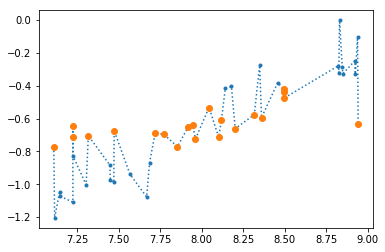

In [44]:
plt.plot(subarrt, subarr, '.:')
plt.plot(subarrt[masko], subarr[masko],'o')

### Slope testing

In [871]:
slope = bug_get_slope(0.25, 1.2652784536739390)(time_sub[239:249], noise_journey_sub[239:249])

In [867]:
get_slope(time_sub[239:249], noise_journey_sub[239:249])

-0.18172501566805382

In [885]:
aaa,bbb = 181,201
meano = 0.9723058514956978

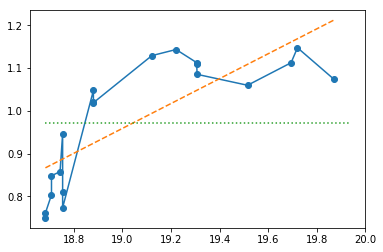

In [889]:
slope = bug_get_slope(0.25, meano)(time_sub[aaa:bbb], noise_journey_sub[aaa:bbb])

plt.plot(time_sub[aaa:bbb], noise_journey_sub[aaa:bbb], 'C0o-')
plt.plot(time_sub[aaa:bbb], slope*(time_sub[aaa:bbb]-time_sub[aaa:bbb].mean())+noise_journey_sub[aaa:bbb].mean(), 'C1--')
plt.plot([time_sub[aaa],time_sub[bbb]], [meano,meano], 'C2:')